In [1]:
import os, sys, pathlib
import argparse
import logging
from tqdm import tqdm

import uproot
import numpy as np
import pandas as pd
import awkward as ak
np.seterr(divide='ignore', invalid='ignore')

from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
from scipy.stats import norm

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.ROOT)
plt.rcParams.update({"font.size": 32})
plt.rcParams.update({"image.cmap": "Purples"})
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
fname = "/data/ge21/qc8/runs/tracks/00010107.root"
with uproot.open(fname) as track_file:
    track_tree = track_file["trackTree"]
    events = track_tree.arrays(
        [
        "rechitChamber", "rechitEta",
        "rechitLocalX", "rechitLocalY", "rechitClusterSize",
        "rechitR", "rechitPhi",
        "trackSlopeX", "trackSlopeY",
        "partialTrackChamber", "partialTrackChi2",
        "partialTrackSlopeX", "partialTrackSlopeY",
        "partialProphitGlobalX", "partialProphitGlobalY",
        "partialProphitEta"
        ]#, entry_stop=100000
    )

In [3]:
rechits_chamber = events["rechitChamber"]
rechits_eta = events["rechitEta"]
rechits_cluster_size = events["rechitClusterSize"]
rechits_x = events["rechitLocalX"]
rechits_y = events["rechitLocalY"]
rechits_r = events["rechitR"]
rechits_phi = events["rechitPhi"]

prophits_chamber = events["partialTrackChamber"]
prophits_chi2 = events["partialTrackChi2"]
prophits_eta = events["partialProphitEta"]
prophits_x = events["partialProphitGlobalX"]
prophits_y = events["partialProphitGlobalY"]

slope_x = events["partialTrackSlopeX"]
slope_y = events["partialTrackSlopeY"]

In [4]:
list_chambers = np.unique(ak.flatten(rechits_chamber))
n_chambers = len(list_chambers)
print("{} chambers in setup".format(n_chambers))
list_eta = np.unique(ak.values_astype(ak.flatten(rechits_eta), int))
n_eta = len(list_eta)
print("{} eta partitions in setup".format(n_eta))
print(list_chambers)
print(list_eta)

20 chambers in setup
4 eta partitions in setup
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[1, 2, 3, 4]


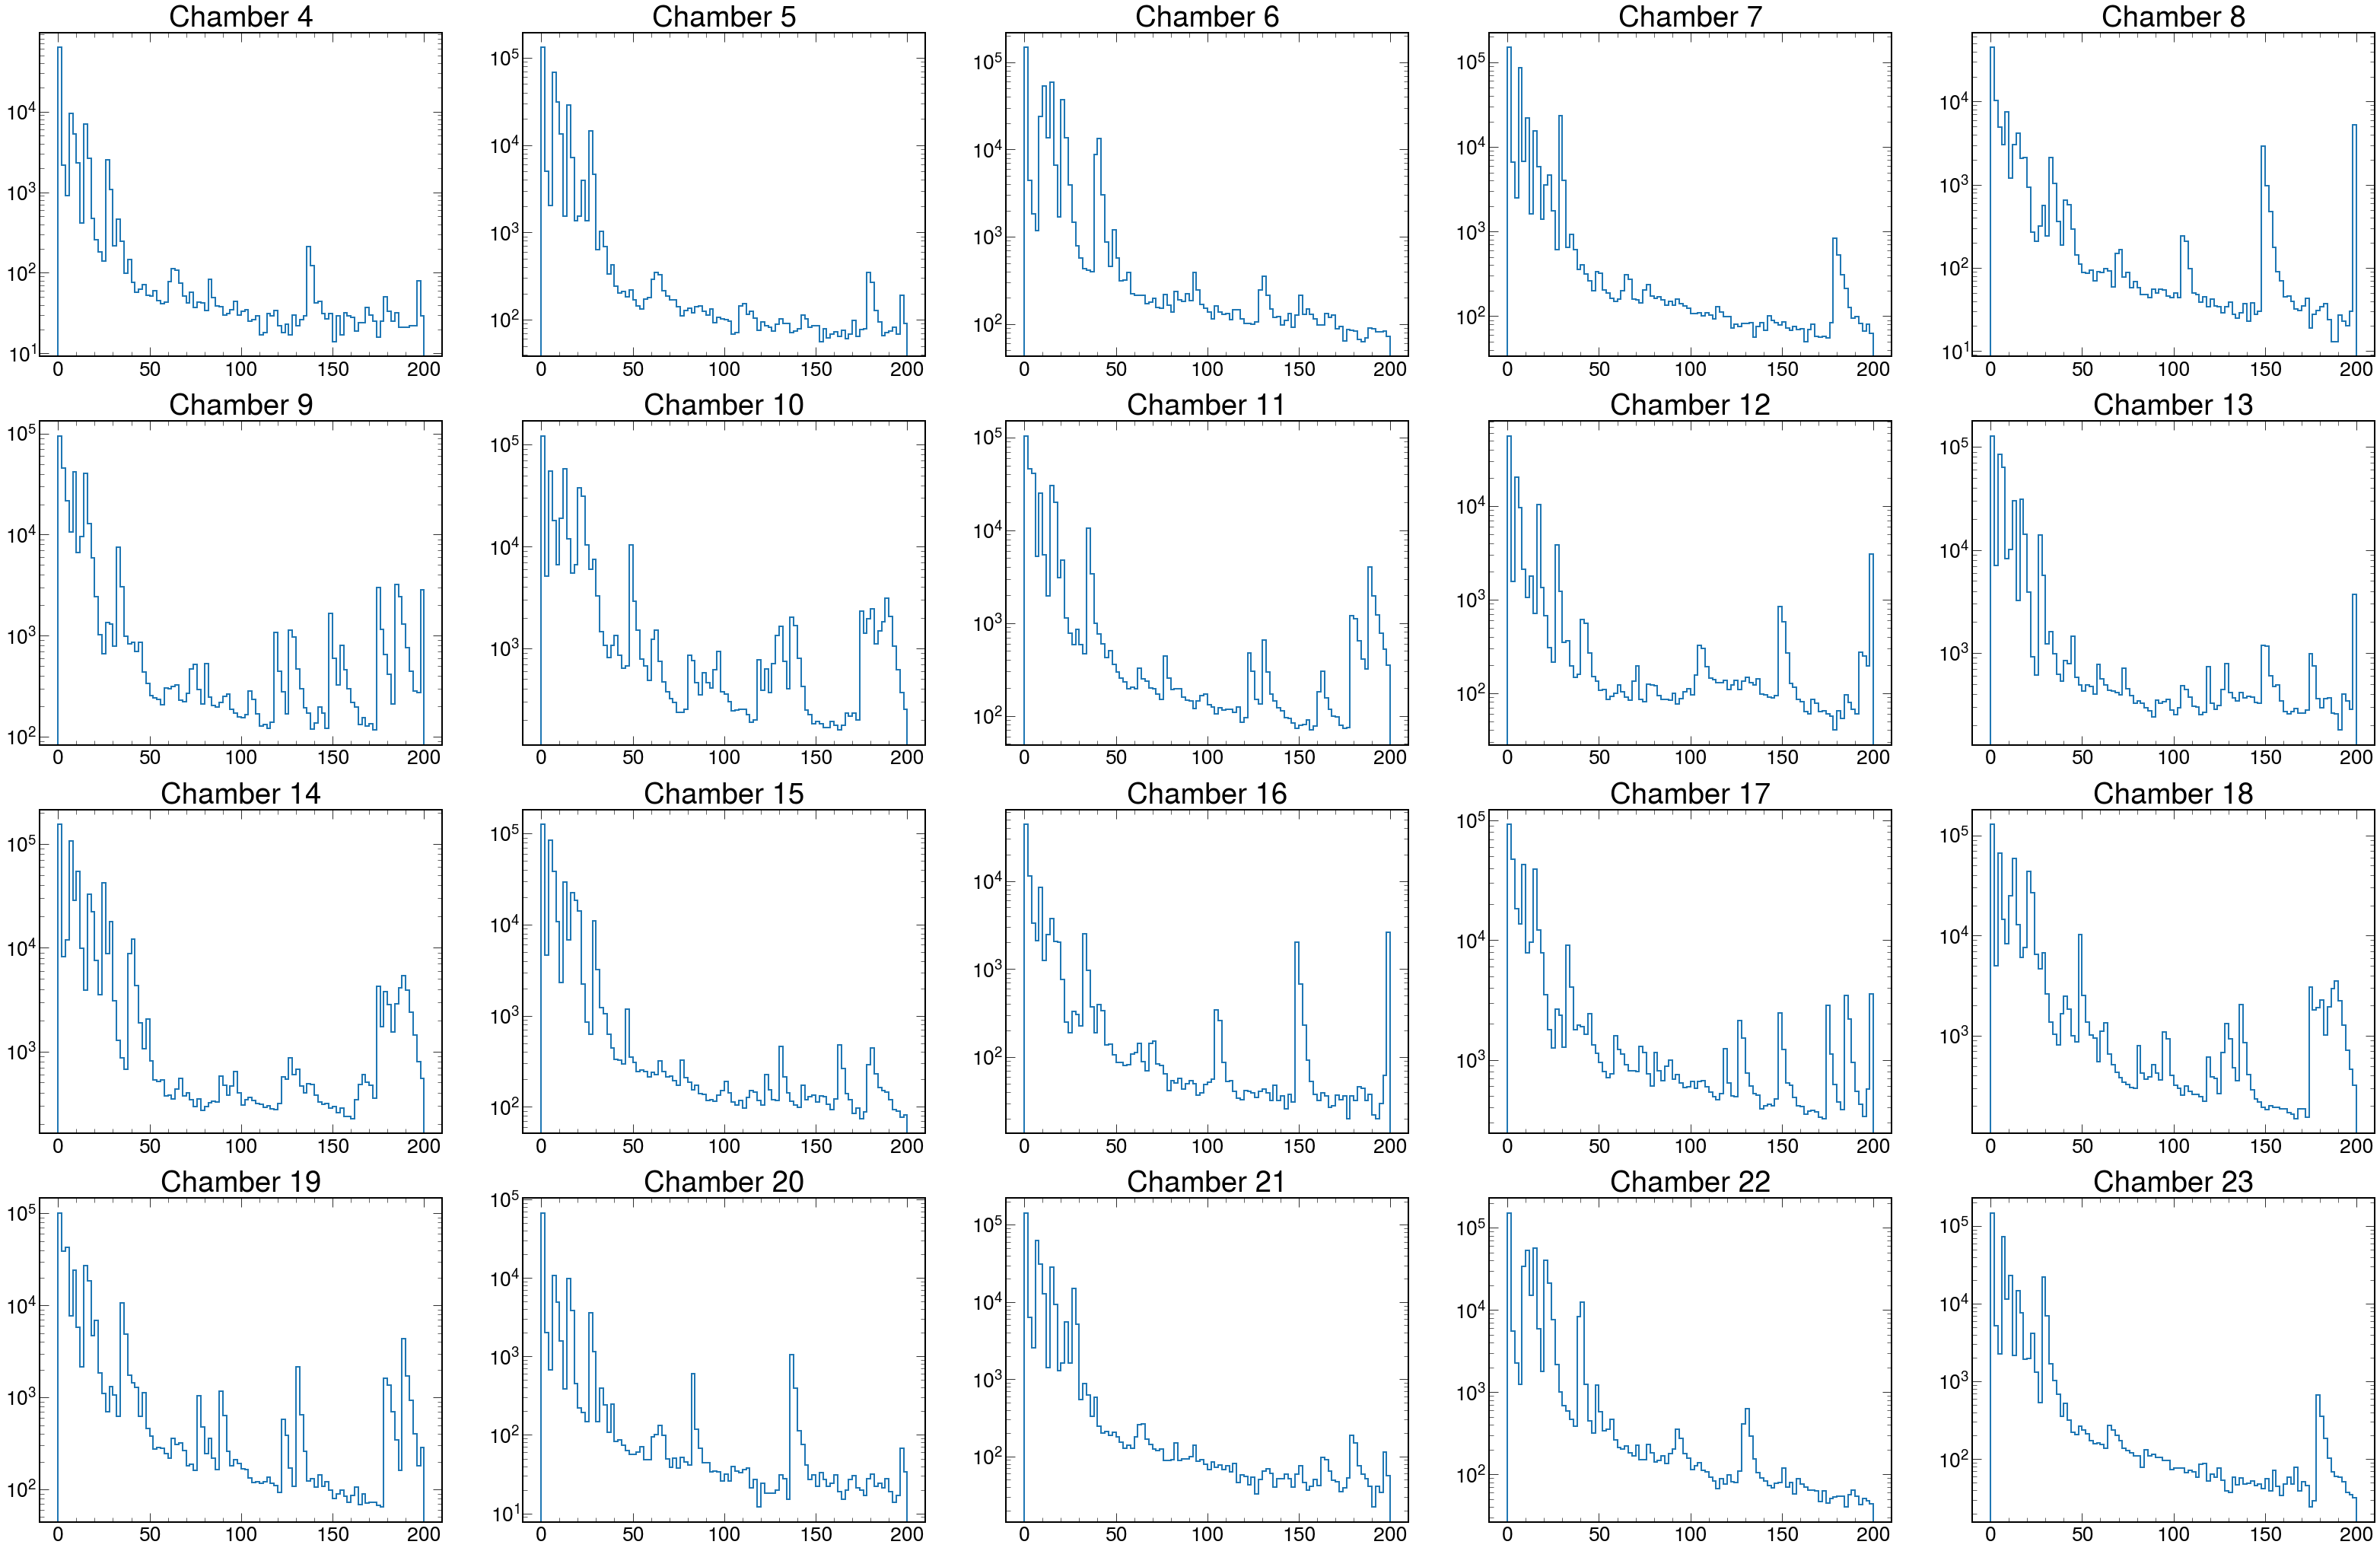

In [5]:
nrows = int(n_chambers**0.5)
ncols = np.ceil(n_chambers/nrows).astype(int)
chi2_fig, chi2_axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11*ncols,9*nrows))

for ichamber,tested_chamber in enumerate(list_chambers):

    prophits_chi2_chamber = prophits_chi2[prophits_chamber==tested_chamber]
    chi2_axs.flat[ichamber].hist(
        ak.flatten(prophits_chi2_chamber),
        bins=100, range=(0,200),
        histtype="step", linewidth=2
    )
    chi2_axs.flat[ichamber].set_yscale("log")
    chi2_axs.flat[ichamber].set_title("Chamber {}".format(tested_chamber))

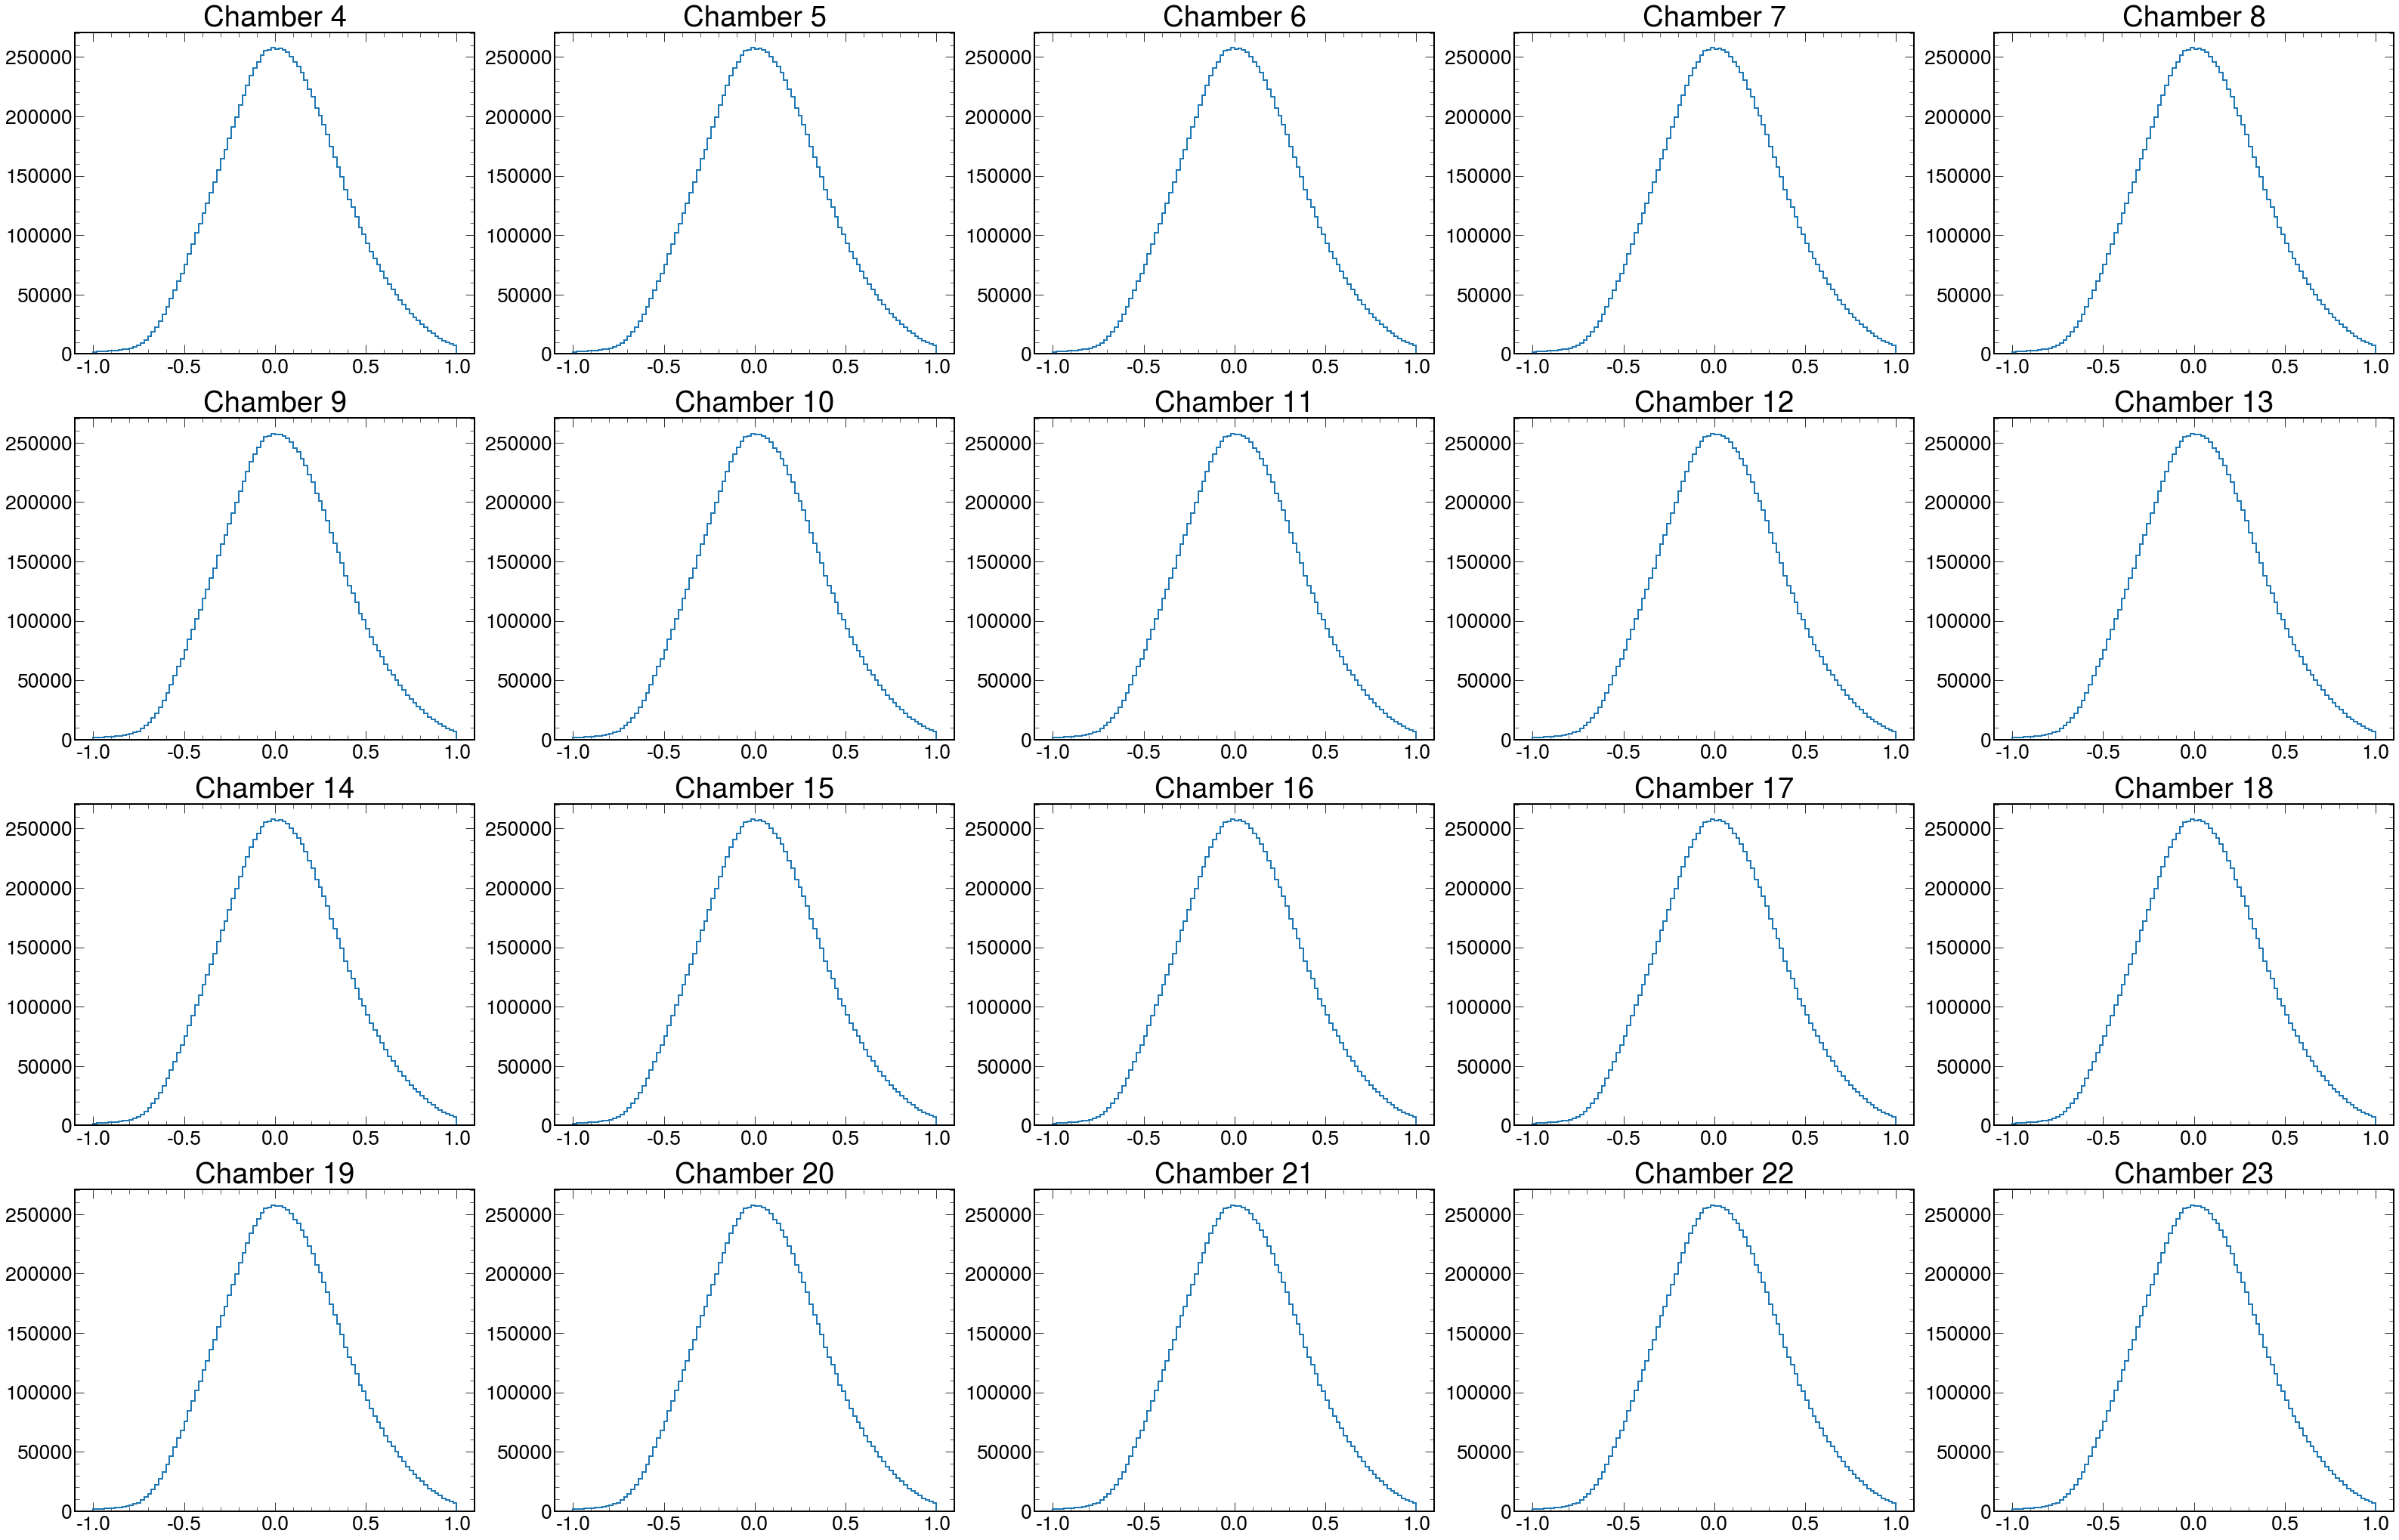

In [6]:
nrows = int(n_chambers**0.5)
ncols = np.ceil(n_chambers/nrows).astype(int)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11*ncols,9*nrows))

for ichamber,tested_chamber in enumerate(list_chambers):

    slope_x_chamber = slope_x[prophits_chamber==tested_chamber]
    axs.flat[ichamber].hist(
        ak.flatten(slope_x),
        bins=100, range=(-1000e-3,1000e-3),
        histtype="step", linewidth=2
    )
    axs.flat[ichamber].set_title("Chamber {}".format(tested_chamber))

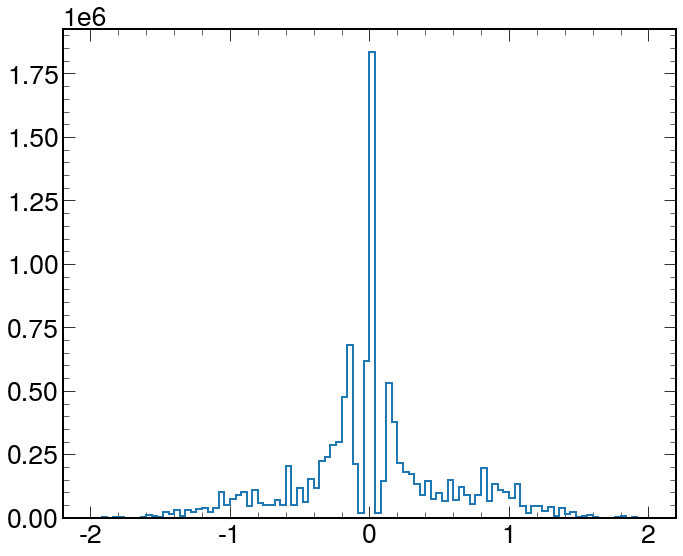

In [7]:
nrows = int(n_chambers**0.5)
ncols = np.ceil(n_chambers/nrows).astype(int)
fig, ax = plt.subplots(figsize=(11,9))

tested_chamber = 8
slope_y_chamber = slope_y[prophits_chamber==tested_chamber]
_ = ax.hist(
    ak.flatten(slope_y),
    bins=100, range=(-2,2),
    histtype="step", linewidth=2
)

In [29]:
tested_chamber = 8
tested_eta = 1

""" Filter by chamber """

rechits_cluster_size_chamber = rechits_cluster_size[rechits_chamber==tested_chamber]
rechits_eta_chamber = rechits_eta[rechits_chamber==tested_chamber]
rechits_x_chamber = rechits_x[rechits_chamber==tested_chamber]
rechits_y_chamber = rechits_y[rechits_chamber==tested_chamber]
rechits_r_chamber = rechits_r[rechits_chamber==tested_chamber]
rechits_phi_chamber = rechits_phi[rechits_chamber==tested_chamber]

prophits_eta_chamber = prophits_eta[prophits_chamber==tested_chamber]
prophits_x_chamber = prophits_x[prophits_chamber==tested_chamber]
prophits_y_chamber = prophits_y[prophits_chamber==tested_chamber]
prophits_chi2_chamber = prophits_chi2[prophits_chamber==tested_chamber]
slope_x_chamber = slope_x[prophits_chamber==tested_chamber]
slope_y_chamber = slope_y[prophits_chamber==tested_chamber]

filter_eta = rechits_eta_chamber==tested_eta
rechits_cluster_size_eta = rechits_cluster_size_chamber[filter_eta]
rechits_x_eta = rechits_x_chamber[filter_eta]
rechits_y_eta = rechits_y_chamber[filter_eta]
rechits_r_eta = rechits_r_chamber[filter_eta]
rechits_phi_eta = rechits_phi_chamber[filter_eta]

""" Filter by eta partition """
prophits_x_eta = prophits_x_chamber[prophits_eta_chamber==tested_eta]
prophits_y_eta = prophits_y_chamber[prophits_eta_chamber==tested_eta]
prophits_chi2_eta = prophits_chi2_chamber[prophits_eta_chamber==tested_eta]
slope_x_eta = slope_x_chamber[prophits_eta_chamber==tested_eta]
slope_y_eta = slope_y_chamber[prophits_eta_chamber==tested_eta]

Text(0, 1, 'Events / 100 µm')

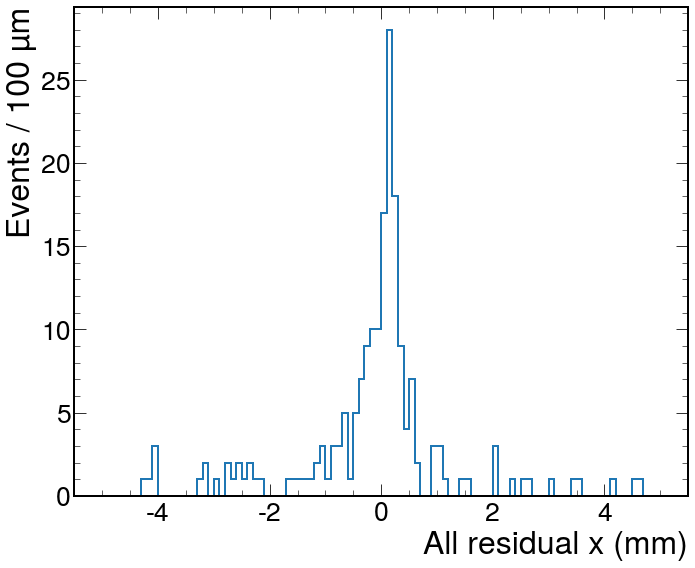

In [33]:
fig, ax = plt.subplots(figsize=(11,9))

slope_x_cut = 100e-3
slope_y_cut = 0.01#*1e5
track_quality_filter = (prophits_chi2_eta<10)&(prophits_chi2_eta>0.001)
track_quality_filter = track_quality_filter&(abs(slope_x_eta)<slope_x_cut)
track_quality_filter = track_quality_filter&(abs(slope_y_eta)<slope_y_cut)

""" Apply cuts based on quality """
prophits_x_eta_filtered = prophits_x_eta[track_quality_filter]
prophits_y_eta_filtered = prophits_y_eta[track_quality_filter]
slope_y_eta_filtered = slope_y_eta[track_quality_filter]
slope_x_eta_filtered = slope_x_eta[track_quality_filter]

""" Process events for residuals """
# choose only events with both a prophit and a rechit and broadcast the prophits
residual_filter = (ak.count(rechits_x_eta, axis=1)>0)&(ak.count(prophits_x_eta_filtered, axis=1)>0)
rechits_x_broadcast, prophits_x_broadcast = ak.broadcast_arrays(
        rechits_x_eta[residual_filter],
        ak.flatten(prophits_x_eta_filtered[residual_filter])
)
rechits_y_broadcast, prophits_y_broadcast = ak.broadcast_arrays(
        rechits_y_eta[residual_filter],
        ak.flatten(prophits_y_eta_filtered[residual_filter])
)

""" Calculate residuals """
#position_filter = abs(prophits_x_broadcast)>10
residuals_y = rechits_y_broadcast-prophits_y_broadcast
residuals_x = rechits_x_broadcast-prophits_x_broadcast
#residuals_x_flat = residuals_x[ak.argmin(residuals_x, axis=1, keepdims=True)].to_numpy()
residuals_x_flat = ak.flatten(residuals_x).to_numpy()

counts, x_edges, _ = ax.hist(
    residuals_x_flat,
    histtype="step", linewidth=2,
    bins=100, range=(-5,5),
)
x_centers = 0.5*(x_edges[1:]+x_edges[:-1])
residuals_binning = np.diff(x_edges).mean()

ax.set_xlabel("All residual x (mm)")
ax.set_ylabel(f"Events / {residuals_binning*1e3:1.0f} µm")

In [34]:
fig, ax = plt.subplots(figsize=(11,9))

matching_cut = 5

print(abs(residuals_x)<matching_cut)
print(ak.count(abs(residuals_x)<matching_cut, axis=1))
print((ak.count(abs(residuals_x)<matching_cut, axis=1)==1)[:12])
print((ak.count(abs(residuals_x)<matching_cut, axis=1)>0)[:12])
print(prophits_x_eta_filtered)
print(ak.count(prophits_x_eta_filtered))

""" Plot numerator and denominator profiles for efficiency calculation """                                                                                                      
prophit_region, prophit_bins = (-60, 60), 21
prophit_binning = (prophit_region[1]-prophit_region[0])/prophit_bins*1e3
event_has_match = ak.count_nonzero(abs(residuals_x)<matching_cut, axis=1)>0
prophits_matching = prophits_x_eta_filtered[residual_filter][event_has_match]
print(prophits_matching)
prophits_total = prophits_x_eta_filtered
matching_counts, matching_edges, _ = ax.hist(                                                                                                         
    ak.flatten(prophits_matching),                                                                                                                                              
    bins=prophit_bins, range=prophit_region,                                                                                                                                    
    histtype="step", label="Matching", color="red"
)                                                                                                                                                                               
total_counts, total_edges, _ = ax.hist(                                                                                                               
    ak.flatten(prophits_total),                                                                                                                                                 
    bins=prophit_bins, range=prophit_region,                                                                                                                                    
    histtype="step", label="Total", color="blue"                                                                                                                                
)                                                                                                                                                                               
ax.set_xlabel("Prophit x (mm)")                                                                                                                       
ax.set_ylabel(f"Events / {prophit_binning:1.0f} µm")                                                                                                  
ax.legend()

[[True, True, True], [True], [True], ... [True], [True], [True, True, False]]
[3, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 3]
[False, True, True, True, True, False, False, True, True, True, True, True]
[True, True, True, True, True, True, True, True, True, True, True, True]
[[], [], [], [], [], [], [], [], [], [], ... [], [], [], [], [], [], [], [], [], []]
215
[[16.7], [-1.67], [-12.7], [-25.1], [-4.97, ... [10.3], [-5], [-22.2], [-5.03]]


In [35]:
fig, ax = plt.subplots(figsize=(11,9))

""" Plot efficiency profile """                                                                                                                                                 
efficiency = np.divide(matching_counts, total_counts, out=np.zeros_like(matching_counts))                                                                                                                                     
x_centers = 0.5*(matching_edges[1:]+matching_edges[:-1])                                                                                                                        
x_errors = np.diff(matching_edges)/np.sqrt(12)                                                                                                                                  
efficiency_errors = np.sqrt(efficiency*(1-efficiency)/total_counts)                                                                                                             
ax.errorbar(x_centers, efficiency, xerr=x_errors, yerr=efficiency_errors, fmt="ok")                                                         
ax.set_ylim(0., 1.05)                                                                                                                       
ax.set_xlabel("Propagated x (mm)")                                                                                                          
ax.set_ylabel("Efficiency")

avg_efficiency = np.mean(efficiency[~np.isnan(efficiency)])
print(efficiency)
print(avg_efficiency)
ax.annotate(
    f"Average efficiency = {avg_efficiency:1.3f}", (25, 0.2), ha="right"
)

[       nan        nan        nan        nan        nan 0.77777778
 0.86666667 0.75862069 0.79310345 0.80952381 0.72727273 0.94736842
 0.68181818 0.625      0.93333333 0.66666667        nan        nan
        nan        nan        nan]
0.7806501565493481


Text(25, 0.2, 'Average efficiency = 0.781')